# Paramagnetic Effects: Contact shift

In [1]:
import sys
sys.path.append('/Users/albertsmith/Documents/GitHub.nosync')
sys.path.append('/Users/albertsmith/Documents/GitHub')
import pyRelaxSim as RS
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

## Build the spin-system

In [13]:
ex=RS.ExpSys(v0H=850,Nucs=['13C','e-'],T_K=298)
Aiso=5000
ex.set_inter(Type='hyperfine',i0=0,i1=1,Axx=Aiso,Ayy=Aiso,Azz=Aiso)
print(f'We expect a contact shift of {Aiso/2*ex.Peq[1]:.2f} Hz')

We expect a contact shift of -112.55 Hz


## Define the Liouvillian, add relaxation, acquire the propagator

We will run two simulations. In the first, there will be no relaxation present, just thermal polarization. In the latter, we'll add electron $T_1$ (and $T_2$, to keep physical behaviour).

Note that by default, we do not cause the system to relax to thermal equilibrium, but rather to 0. However, for the Pseudocontact shift, we only obtain the effect if the electronic states have thermal polarization, so we need to enforce relaxation to thermal equilibrium (L.add_relax(Type='recovery')).

<IPython.core.display.Javascript object>


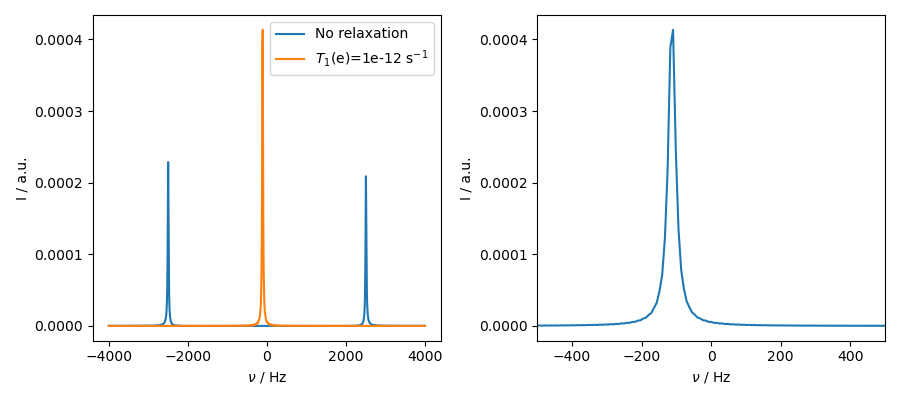

In [14]:
L=RS.Liouvillian(ex)     #Liouville object
dt=1/4000/2 #Short enough time step for 8000 Hz spectral width
U=L.U(Dt=dt)
seq=L.Sequence()
seq.add_channel('13C',t=[0,2.5e-6],v1=100000,phase=np.pi/2)
Upi2=seq.U()

fig,ax=plt.subplots(1,2)
fig.set_size_inches([9,4])
#First without relaxation
rho=RS.Rho(rho0='Thermal',detect='13Cp')
(Upi2*rho)    #Apply the pi/2 pulse
rho.DetProp(U,n=512)
rho.plot(ax=ax[0],axis='Hz',FT=True,apodize=True)

#Now add T1 relaxation
L.add_relax(Type='T1',i=1,T1=1e-12)
L.add_relax(Type='T2',i=1,T2=1e-12)
L.add_relax(Type='recovery')
U=L.U(Dt=dt)
Upi2=seq.U()  #We can recycle sequence, but need to re-generate the propagator with the changes

rho.clear()   #Reset the density operator
(Upi2*rho)    #Apply the pi/2 pulse
rho.DetProp(U,n=512)
rho.plot(ax=ax[0],axis='Hz',FT=True,apodize=True)
ax[0].legend(('No relaxation',r'$T_1$(e)=1e-12 s$^{-1}$'))
rho.plot(ax=ax[1],axis='Hz',FT=True,apodize=True)
_=ax[1].set_xlim([-500,500])
fig.tight_layout()

Without relaxation, we obtain two peaks at $\pm$2500 Hz, with the peak at -2500 Hz being slightly higher in amplitude, due to the higher electron polarization for that state. When electron $T_1$ is included, the two peaks get averaged together, weighted according to their amplitude, yielding the peak at -112 Hz. 

## Sweep the temperature
An interesting effect with the contact shift is its dependence on temperature. As we increase temperature here, first, the peak gets smaller due to less polarization on the spin, and the contact shift is decreased, since the electron polarization is decreased.

<IPython.core.display.Javascript object>


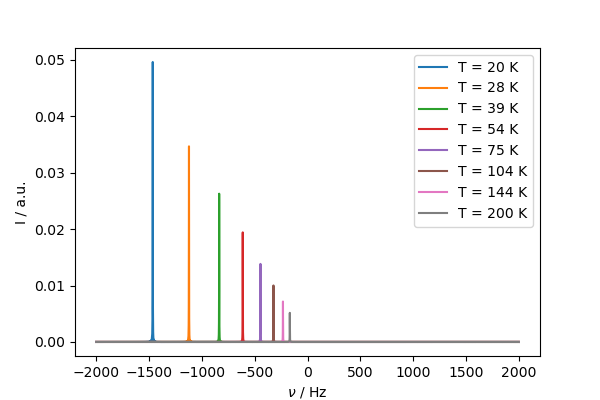

In [15]:
rho=RS.Rho(rho0='Thermal',detect='13Cp')
seq=RS.Sequence(L)
seq.add_channel('13C',t=[0,2.5e-6],v1=[100000,0],phase=[np.pi/2,0])

dt=1/2000/2 #Short enough time step for 4000 Hz spectral width
ax=plt.figure().add_subplot(111)
T=np.logspace(np.log10(20),np.log10(200),8)
for T_K in T:
    ex.T_K=T_K
    L.clear_relax()
    L.add_relax(Type='T1',i=1,T1=1e-12)  #Add T1 relaxation (1 ns). 
    L.add_relax(Type='T2',i=1,T2=1e-12) #Add T2 relaxation (ensure physical system)
    L.add_relax(Type='recovery')
    Upi2=seq.U()
    U=L.U(t0=0,Dt=dt)
    rho.clear()
    Upi2*rho
    rho.DetProp(U,n=4096)
    rho.plot(FT=True,apodize=True,ax=ax,axis='Hz')
ax.figure.set_size_inches([6,4])
ax.legend([f'T = {T_K:.0f} K' for T_K in T])


# Pseudo-contact shift
The shift in the NMR peak due to an isotropic coupling to the electron is known as the contact shift. The pseudo-contact shift is considerably more complex. Since it arises from the anisotropic part of the hyperfine coupling, an electron with quantization axis along the magnetic field's $z$-axis will not yield a pseudo-contact shift. This is because the average size of the orientationally-averaged coupling is zero. On the other hand, if, due to an anisotropic g-tensor, the electron's quantization axis is tilted away from $z$, then the anisotropic part of the hyperfine coupling to the nuclear will not fully average out. 

Actually simulating this effect is a bit difficult. First, we need the full tensors for the electrons, so we have to simulate in the lab frame. Second, our $T_1$ implementation always is applied to the Zeeman-defined states, but we actually require electron relaxation to occur along the quantization axis. Therefore, we induce the electron relaxation indirectly, via motion of the electron g-tensor (we still have to put the terms in to induce relaxation towards therm

In [16]:
# ex0=RS.ExpSys(v0H=850,Nucs=['13C','e-'],T_K=100,LF=[True,True])
# ex0.set_inter('g',i=1,gxx=1,gyy=1,gzz=4,euler=[np.pi/4,3*np.pi/5,0])
# ex0.set_inter('hyperfine',i0=0,i1=1,Axx=-20000,Ayy=-20000,Azz=40000,euler=[np.pi/3,np.pi/4,0])
# ex1=ex0.copy()
# ex1.set_inter('g',i=1,gxx=1,gyy=1,gzz=4,euler=[[np.pi/4,3*np.pi/5,0],[0,np.pi/8,0]])

# L=RS.Liouvillian((ex0,ex1))
# L.kex=RS.Tools.twoSite_kex(tc=1e-12)

delta=2e4

ex=[]   #Since we have four states in exchange, we'll put them in a list
ex.append(RS.ExpSys(v0H=600,vr=0,Nucs=['13C','e-'],T_K=200,LF=True,pwdavg=RS.PowderAvg()[20]))     #1-spin system at 600 MHz (14.1 T). LF=True : Lab Frame
ex[-1].set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
ex[-1].set_inter('g',i=1,gxx=1,gyy=1,gzz=4,euler=[np.pi/4,3*np.pi/5,0])


phi_tetra=np.arccos(-1/3)
for k in range(3):
    ex.append(ex[0].copy())
    ex[-1].set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta,euler=[0,phi_tetra,k*2*np.pi/3])
    ex[-1].set_inter('g',i=1,gxx=1,gyy=1,gzz=4,euler=[[np.pi/4,3*np.pi/5,0],[0,phi_tetra,k*2*np.pi/3]])

L=RS.Liouvillian(ex)
L.kex=RS.Tools.fourSite_sym(tc=1e-9)
# L.kex=RS.Tools.twoSite_kex(tc=1e-9)


L.add_relax(Type='T1',i=1,T1=1e-12)
L.add_relax(Type='T2',i=1,T2=1e-12)
L.add_relax(Type='recovery')

First, we check that the electron relaxation is sufficiently fast

<IPython.core.display.Javascript object>


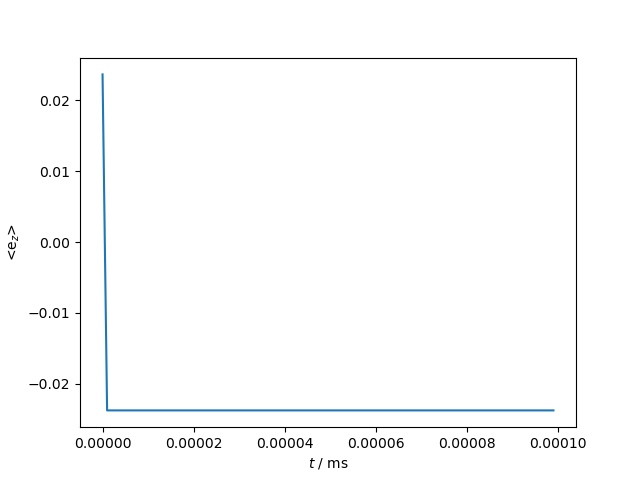

<AxesSubplot:xlabel='$t$ / ms', ylabel='<e$_z$>'>

In [10]:
U=L.U(Dt=1e-9)
rho=RS.Rho(rho0='-ez',detect='ez')
rho.DetProp(U,n=100)
rho.plot()

In [11]:
L.reset_prop_time()
U=L.U(Dt=2e-3)
# U=L.U()**100

<IPython.core.display.Javascript object>


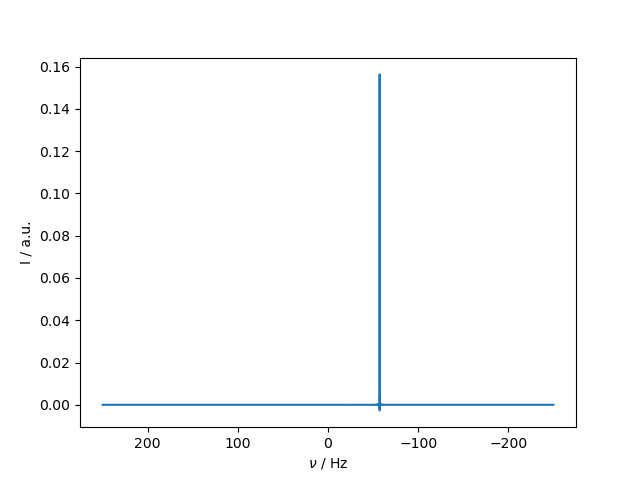

<AxesSubplot:xlabel='$\\nu$ / Hz', ylabel='I / a.u.'>

In [12]:
rho=RS.Rho(rho0='13Cx',detect='13Cp')
rho.DetProp(U,n=40000)
rho.downmix()
rho.plot(FT=True)